In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from linearmodels import PanelOLS
from linearmodels import RandomEffects

df = pd.read_stata('pwt91.dta')
df['y'] = df['rgdpna']/df['pop']
df['l'] = df['cgdpe']/df['pop']
df.dropna(subset=['y','l'],inplace=True)

df.head()

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k,y,l
20,ABW,Aruba,Aruban Guilder,1970,349.329803,427.473602,0.059063,NaN,NaN,NaN,...,-0.000451,0.644299,0.302037,0.737015,0.949097,0.928951,0.446654,NaN,5828.662598,6137.742676
21,ABW,Aruba,Aruban Guilder,1971,380.771179,466.320007,0.059440,NaN,NaN,NaN,...,-0.000451,0.627038,0.287922,0.705255,0.898551,0.912678,0.427064,NaN,6318.070801,6682.600098
22,ABW,Aruba,Aruban Guilder,1972,415.343994,508.698639,0.059840,NaN,NaN,NaN,...,-0.000451,0.610470,0.276999,0.671196,0.865215,0.899579,0.405489,NaN,6846.216309,7244.649414
23,ABW,Aruba,Aruban Guilder,1973,453.113220,554.925476,0.060243,NaN,NaN,NaN,...,-0.000451,0.594909,0.265591,0.649643,0.748246,0.831398,0.385853,NaN,7418.472656,7848.138672
24,ABW,Aruba,Aruban Guilder,1974,492.720642,605.343994,0.060528,NaN,NaN,NaN,...,-0.000451,0.574585,0.248030,0.623670,0.555225,0.674676,0.363743,1.719289,8054.594238,8671.312500


In [4]:
table = pd.pivot_table(df,index=['country','year'],values=['y','l','hc','csh_i','csh_x','csh_m'])

for i in df['country'].unique():
    table.loc[i,'g'] = np.log(table.loc[i,'y']).diff(5).rolling(5).mean().values
    table.loc[i,'level'] = (table.loc[i,'l']/table.loc['United States','l']).dropna().values
    
    for j in ['hc','csh_i','csh_x','csh_m']:
        table.loc[i,j] = table.loc[i,j].rolling(5).mean().values
        
table['csh_m'] = - table['csh_m']
table.reset_index(inplace=True)
table = table[table['year']%5==0].dropna(subset=['g'])
data = table.set_index(['country','year']).dropna()
    
data.to_csv('convergence_data.csv')
data.head(10)

csh_i     csh_m     csh_x        hc             l  \
country year                                                         
Albania 1980  0.185131  0.029893  0.038188  1.809517   3139.266602   
        1985  0.186827  0.053923  0.067928  2.100400   3146.600342   
        1990  0.147000  0.031245  0.050035  2.409648   3137.950928   
        1995  0.052540  0.154539  0.040901  2.514883   3381.277100   
        2000  0.100148  0.156546  0.036501  2.690044   4286.904297   
        2005  0.244203  0.263846  0.055541  2.843253   5868.390625   
        2010  0.315083  0.333249  0.078347  2.891040   9201.562500   
        2015  0.231810  0.287390  0.105557  2.924075  10700.171875   
Algeria 1970  0.335406  0.074842  0.208063  1.164431   5330.145020   
        1975  0.447072  0.085403  0.153031  1.195142   7938.131836   

                         y         g     level  
country year                                    
Albania 1980   4775.535645  0.086286  0.109134  
        1985   4774.414062  0.055835  0.095860  
        1990   4408.375000 -0.037488  0.086071  
        1995   4183.825195 -0.315393  0.085960  
        2000   5321.465820  0.304457  0.093360  
        2005   7176.951172  0.316887  0.115752  
        2010   9719.379883  0.309909  0.184967  
        2015  10683.408203  0.167732  0.198560  
Algeria 1970   8015.315430  0.123813  0.226481  
        1975   8844.142578  0.157403  0.311319

In [3]:
mod = PanelOLS.from_formula('g ~ 1 + np.log(level) + np.log(hc) + csh_i + EntityEffects',data=data).fit()
mod.summary

RuntimeError: Cannot set name on a level of a MultiIndex. Use 'MultiIndex.set_names' instead.

In [16]:
from linearmodels import BetweenOLS

table1 = pd.pivot_table(df,index=['country','year'],values=['l','y','hc','csh_i','csh_x','csh_m'])
for i in df['country'].unique():
    table1.loc[i,'g'] = np.log(table1.loc[i,'y']).diff(5).values
    table1.loc[i,'level'] = (table1.loc[i,'l']/table1.loc['United States','l']).dropna().values

    
mod1 = BetweenOLS.from_formula('g ~ np.log(level)',data=data).fit()
mod1.summary

Dep. Variable:,g,R-squared:,0.5643
Estimator:,BetweenOLS,R-squared (Between):,0.5643
No. Observations:,69,R-squared (Within):,-0.0182
Date:,"Fri, Jan 17 2020",R-squared (Overall):,0.3998
Time:,10:29:49,Log-likelihood,62.115
Cov. Estimator:,Unadjusted,,
,,F-statistic:,88.065
Entities:,70,P-value,0.0000
Avg Obs:,7.9714,Distribution:,"F(1,68)"
Min Obs:,0.0000,,
Max Obs:,12.000,F-statistic (robust):,88.065


In [19]:
import statsmodels.formula.api as smf

res = smf.ols('g ~ np.log(level) + np.power(np.log(level),2)',data).fit(cov_type='HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      g   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     6.734
Date:                Fri, 17 Jan 2020   Prob (F-statistic):            0.00129
Time:                        10:30:19   Log-Likelihood:                 496.90
No. Observations:                 558   AIC:                            -987.8
Df Residuals:                     555   BIC:                            -974.8
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.1131      0.006     19.034      0.000       0.101       0.125
np.log(level)                 -0.0427      0.014     -3.102      0.002      -0.070      -0.016
np.power(np.log(level), 2)    -0.0104      0.005     -2.225      0.026      -0.020      -0.001
==============================================================================
Omnibus:                       16.394   Durbin-Watson:                   0.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.309
Skew:                           0.115   Prob(JB):                     9.64e-08
Kurtosis:                       4.156   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

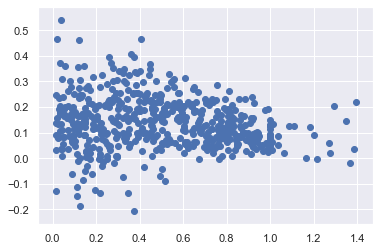

In [18]:
plt.scatter(data['level'],data['g'])